In [142]:
import importlib

import os
import torch
import datetime
import pandas as pd
import numpy as np
import scipy.stats as sc
import geopandas as gp
from torch.autograd import Variable

import paths
from apollo import mechanics as ma
from apollo import streamflow as strf
from apollo import metrics as me

from train_model import load_data, train

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

In [ ]:
### Set global model parameters
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [174]:
station = 45009
df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_gdf.csv'))
boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))
df

,file,timestamp,2024-05-10T15:47:42
0,database,id,nrfa-public-30
1,database,name,UK National River Flow Archive
2,station,id,45009
3,station,name,Exe at Pixton
4,station,gridReference,SS9349325960
...,...,...,...
20624,2022-09-26,0.845,NaN
20625,2022-09-27,0.819,NaN
20626,2022-09-28,0.872,NaN
20627,2022-09-29,1.052,NaN


In [175]:
filename = paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_lumped.csv')
rf = pd.read_csv(filename)
rf['Date'] = pd.to_datetime(rf['Date'], format='%Y-%m-%d').dt.date
#rf = rf.drop(rf.index[:552])
len_before = len(rf)
rf = rf.dropna(subset=['Flow'])
print(len_before-len(rf), 'values are missing.')
rf

0 values are missing.


,Unnamed: 0,Date,Flow,Temperature,U Windspeed,V Windspeed,Humidity,Rain,Resultant Windspeed,Rain-1,...,Humidity-25,Humidity-26,Humidity-27,Humidity_28_Mu,Humidity_90_Mu,Humidity_180_Mu,Soil Moisture 1,Soil Moisture 2,Soil Moisture 3,Soil Moisture 4
0,179,1979-06-29,1.140,284.880484,8.766262,-2.879926,64.755251,0.031405,9.227206,0.171336,...,89.711497,82.342304,93.220496,74.235796,74.132368,77.233642,0.283931,0.292571,0.318458,0.386158
1,180,1979-06-30,1.100,284.402393,6.086802,-4.552709,69.657243,0.254117,7.601074,0.031405,...,66.988545,89.711497,82.342304,73.394252,74.075905,77.272269,0.276107,0.288244,0.316652,0.385818
2,181,1979-07-01,1.020,286.016299,2.786090,-5.041719,56.201567,0.000625,5.760315,0.254117,...,82.764458,66.988545,89.711497,72.460654,73.789554,77.232244,0.266814,0.283350,0.314711,0.385479
3,182,1979-07-02,0.969,287.403642,3.509290,-2.407257,72.031583,-0.000011,4.255585,0.000625,...,85.693742,82.764458,66.988545,71.829228,73.649398,77.214319,0.256873,0.277725,0.312541,0.385113
4,183,1979-07-03,0.978,289.812388,-1.058269,0.160969,64.547233,0.007201,1.070441,-0.000011,...,80.330888,85.693742,82.764458,71.742039,73.749931,77.203466,0.248726,0.272552,0.310493,0.384760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15522,15701,2021-12-27,12.130,286.031339,1.399973,3.795947,89.836159,7.179474,4.045879,1.016039,...,65.744526,75.275363,92.325955,85.009395,81.569766,78.973192,0.412561,0.422774,0.398831,0.385694
15523,15702,2021-12-28,11.960,284.479066,10.444399,-2.769657,83.343738,1.891823,10.805391,7.179474,...,92.590164,65.744526,75.275363,84.688601,81.822846,78.974666,0.410266,0.413440,0.402462,0.386165
15524,15703,2021-12-29,17.620,287.868864,11.483446,2.949223,87.529342,10.169532,11.856115,1.891823,...,70.930830,92.590164,65.744526,85.126243,81.873664,79.053846,0.412430,0.425792,0.405656,0.386763
15525,15704,2021-12-30,21.080,286.482149,4.823608,6.324377,93.762562,1.022999,7.953926,10.169532,...,66.743917,70.930830,92.590164,86.126887,82.221159,79.090827,0.400714,0.412358,0.408372,0.387583


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for station in ['7001', '33035', '33039', '54057']:
    
    year = 2012
    boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))
    area = boundary.geometry.area
    
    df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_gdf.csv'))
    name = df.loc[df.index[3]].iloc[2]
    
    filename = paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_lumped.csv')
    rf = pd.read_csv(filename)
    rf['Date'] = pd.to_datetime(rf['Date'], format='%Y-%m-%d').dt.date
    rf = rf.dropna(subset=['Flow'])
    
    rf['NE'] = rf['Flow'].apply(lambda flow: flow/area)
    
    plt.plot(rf['Date'], rf['NE'], label=name) #Temperature, Rain, ...
    plt.ylabel('HE (Hydraulic Efficiency in m3/s/m2)')
    #plt.ylabel('Rain')
    plt.xlim([datetime.date(year, 1, 1), datetime.date(year, 12, 31)])
    plt.ylim(0,0.00000035)
      
plt.legend()
plt.show()

In [ ]:
print('Mean ', rf['Flow'].mean())
print('Deviation ', rf['Flow'].std())
print('Maximum ', rf['Flow'].max())

rf['Flow'].hist()

In [301]:
### Identify features (with either antecedent proxies or soil moisture levels)
days = 6
features = ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] \
            + ['Temperature'] \
            + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Resultant Windspeed'] \
            + ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            + ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)] \
            + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']
            #"+ ['Soil Moisture ' + f'{i+1}' for i in range(4)]
            
###Test/Train data split by years
yearlist = [2010+i for i in range(12)]

trnset, full_set = load_data.preprocess_data(rf, features, yearlist)
trnset

array([[7.31000000e+02, 3.47155200e+08, 1.51600000e+01, ...,
        3.73654272e-01, 3.91731870e-01, 3.84263126e-01],
       [7.32000000e+02, 3.47241600e+08, 1.46300000e+01, ...,
        3.70740785e-01, 3.90913614e-01, 3.84405588e-01],
       [7.33000000e+02, 3.47328000e+08, 1.37600000e+01, ...,
        3.68966100e-01, 3.90077483e-01, 3.84547255e-01],
       ...,
       [1.13200000e+04, 1.26204480e+09, 4.61700000e+01, ...,
        3.80491883e-01, 3.89202700e-01, 3.66699786e-01],
       [1.13210000e+04, 1.26213120e+09, 9.06800000e+01, ...,
        4.19994178e-01, 3.93515048e-01, 3.67119328e-01],
       [1.13220000e+04, 1.26221760e+09, 7.06300000e+01, ...,
        4.19115280e-01, 4.01762523e-01, 3.67795464e-01]])

In [302]:
import importlib
importlib.reload(train)
importlib.reload(load_data)

<module 'train_model.load_data' from 'C:\\Users\\aline\\soil-moisture-proxies\\train_model\\load_data.py'>

In [314]:
import scipy
pd.options.mode.chained_assignment = None

def full_training_loop(rf, features=features, loss_func=None, alpha=1.0, beta=1.0):

    years_eval = [2010 + i for i in range(12)]

    # LOAD DATA
    trnset, full_set = load_data.preprocess_data(rf, features, years_eval)
    targets = ['Flow']
    xspace = ma.featurelocator(rf, features)
    yspace = ma.featurelocator(rf, targets)

    # TRAINING
    x_train = load_data.reshape_input(trnset, xspace)
    y_train = load_data.reshape_output(trnset, yspace)

    network = train.load_network(x_train.shape[1], y_train.shape[1])      
    
    '''
    ## WRONG   
    mu, sigma = scipy.stats.norm.fit(y_train.cpu()) 
    y_total = Variable(load_data.reshape_output(full_set, yspace))
    u_of_y = torch.from_numpy(scipy.stats.norm.pdf(y_total.cpu(), loc=mu, scale=sigma)).to(device)
    #similar to u_of_y_alt = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(y_train.cpu()-mu)**2/(2 * sigma**2)).to(device)
    
    kappa = 1 / (sigma * np.sqrt(2 * np.pi))
    print(kappa)
    psi = me.RELossWeight(u_of_y, alpha=alpha, beta=beta, kappa=kappa) 
    '''
    
    param = sc.lognorm.fit(y_train, loc=0)
    print("Log-normal distribution parameters : ", param)
    shape, loc, scale = param

    # KAPPA (max U(y)) calculation for LOGNORM
    ##??? kappa = np.exp(-2*(shape**2)) * (loc*np.exp(2*(shape**2))+scale)
    kappa_max_x = loc+scale*np.exp(- shape**2)
    kappa_max_y = sc.lognorm.pdf(kappa_max_x, s=shape, scale=scale, loc=loc)

    kappa_direct = np.exp(shape**2/2)/(shape* scale*np.sqrt(2*np.pi))

    u_of_y = sc.lognorm.pdf(y_train, s=shape, scale=scale, loc=kappa_max_y)

    psi = me.RELossWeight(u_of_y, alpha=alpha, beta=beta, kappa=kappa_max_y) 
    
    x_train = Variable(torch.from_numpy(x_train).to(device))
    y_train = Variable(torch.from_numpy(y_train).to(device))
    
    network = train.train(network, x_train, y_train, verbose=False, loss_func_type=loss_func, psi=psi[:len(x_train)])

    # EVALUATION
    x_test = load_data.reshape_input(full_set, xspace)   
    x_test = torch.from_numpy(x_test).to(device)
    rf['Predicted'] = train.evaluate(network, x_test)

    if rf['Date'].dtype == 'float64':
        rf['Date'] = pd.to_datetime(rf['Date'], unit='s').dt.date
    testrf = rf[pd.to_datetime(rf['Date']).dt.year.isin(years_eval)]
    return testrf, rf, network, psi

In [304]:
results_gdf = gp.GeoDataFrame(columns=['Station', 'Name', 'NSE', 'HE_mean', 'HE_std', 'Geometry'])

for station_nr in os.listdir(paths.CATCHMENT_BASINS):
    
    df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
    name = df.loc[df.index[3]].iloc[2]
    print('Processing site "', name, '"')
    
    boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
    rf = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped.csv'), verbose=False)
    
    testrf, rf = full_training_loop(rf)

    # Calculate the NSE
    NSE = me.R2(testrf['Flow'], testrf['Predicted'])
    
    # Calculate the hydraulic efficiency
    HE_mean = (rf['Flow'].mean()/boundary.geometry.area)*(10^6)
    HE_std = (rf['Flow'].std()/boundary.geometry.area)*(10^6)

    # Assuming 'results_gdf' is your existing GeoDataFrame
    new_data = gp.GeoDataFrame({
        'Station': station_nr,
        'Name': name, 
        'NSE': NSE,
        'HE_mean': HE_mean,
        'HE_std': HE_std, 
        'Geometry': boundary.geometry.iloc[0]
    })

    results_gdf = pd.concat([results_gdf, new_data], ignore_index=True)
    
results_gdf    

Processing site " Dee at Polhollick "


TypeError: Variable data has to be a tensor, but got numpy.ndarray

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'results_gdf' is your GeoDataFrame with 'HE' and 'NSE' columns
plt.figure(figsize=(10, 6))

# Scatter plot for the mean values
plt.scatter(results_gdf['HE_mean'], results_gdf['NSE'], color='blue', marker='o')

# Error bars for the standard deviation
#plt.errorbar(results_gdf['HE_mean'], results_gdf['NSE'], xerr=results_gdf['HE_std'], fmt='o', color='blue', capsize=5)

# Adding labels and title
plt.xlabel('Hydraulic Efficiency (HE)')
plt.ylabel('Normalized Squared Error (NSE)')
plt.title('Scatter Plot of HE vs NSE')

# Optional: Adding a line of best fit to help visualize any linear trend
import numpy as np
m, b = np.polyfit(results_gdf['HE_mean'], results_gdf['NSE'], 1)
plt.plot(results_gdf['HE_mean'], m*results_gdf['HE_mean'] + b, color='red')  # Line of best fit

plt.grid(True)
plt.show()

In [ ]:
results_gdf['Area']= results_gdf['Geometry'].apply(lambda geometry: geometry.area)

In [ ]:
import plotly.express as px

# Assuming 'results_gdf' is your GeoDataFrame with 'HE', 'NSE', and 'Station' columns
fig = px.scatter(results_gdf, x='HE_mean', y='NSE', text='Station', 
                 hover_data=['Station'],  # This specifies what data to show on hover
                 title='Interactive Plot of HE vs NSE')

# Adding labels
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color='DarkSlateGrey')), 
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_xaxes(title_text='Hydraulic Efficiency (HE)')
fig.update_yaxes(title_text='Normalized Squared Error (NSE)')

# Show the plot
fig.show()

In [ ]:
importlib.reload(train)
importlib.reload(me)

In [315]:
## REFLECTIVE ERROR IMPLEMENTATION
from scipy.stats import norm

station_nr = 33039
df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
name = df.loc[df.index[3]].iloc[2]
print('Processing site "', name, '"')
    
boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
rf = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped.csv'), verbose=False)

days=27
feature_set = ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] \
            + ['Temperature'] \
            + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Resultant Windspeed'] \
            + ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            + ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)] \
            #+ ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']
            #"+ ['Soil Moisture ' + f'{i+1}' for i in range(4)]


testrf, rf, network, psi = full_training_loop(rf, features=feature_set, loss_func='Reflective', alpha=1, beta=2) # loss_func ='Reflective'

Processing site " Bedford Ouse at Roxton "
Log-normal distribution parameters :  (1.0672634051799166, 1.10003809248887, 6.0590435327120185)
0.1090375776601921
u_of_y [[0.06950008]
 [0.06869487]
 [0.07185336]
 ...
 [0.00931772]
 [0.00236881]
 [0.0011611 ]]
[[1.3626043 ]
 [1.36998907]
 [1.34102203]
 ...
 [1.91454578]
 [1.97827527]
 [1.98935138]]


C:\Users\aline\AppData\Local\Temp\ipykernel_108324\3385652034.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rf['Predicted'] = train.evaluate(network, x_test)


[1.98850386 1.98749507 1.98274232 ... 1.91454578 1.97827527 1.98935138]


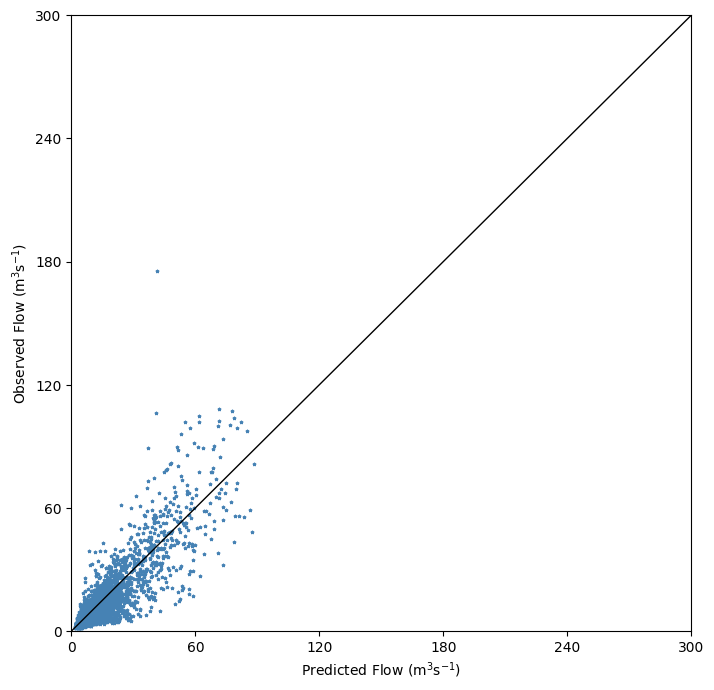

- - - - - - - - - - - - - - -
RMSE: 7.133101022890378
NSE: 0.7444169510860713
RE: 1.2955794366373958
[1.3626043  1.36998907 1.34102203 ... 1.91454578 1.97827527 1.98935138]


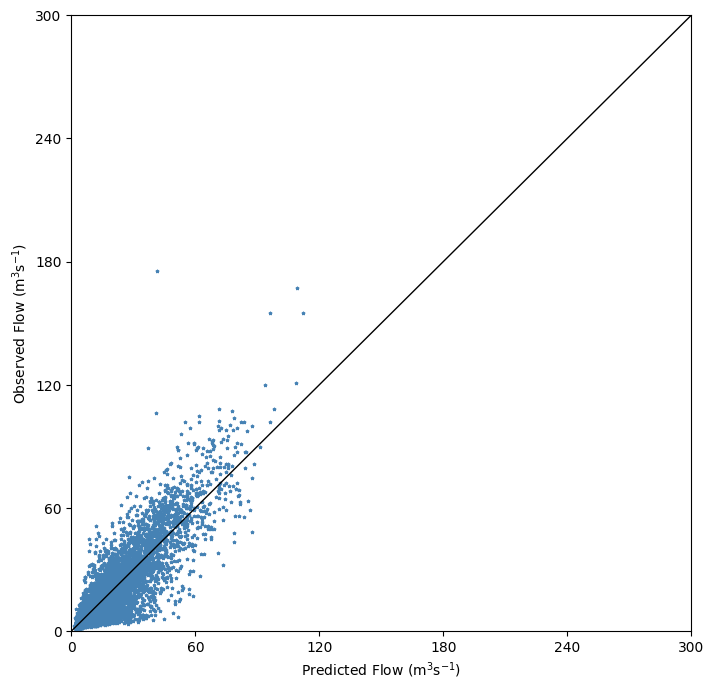

- - - - - - - - - - - - - - -
RMSE: 6.417646098497995
NSE: 0.7890659238067077


ValueError: operands could not be broadcast together with shapes (15398,) (11021,) 

In [316]:
maxflow = 300

for df in (testrf, rf):
    
    psi_df = psi[-len(df):].squeeze()
    print(psi_df)
    
    strf.scatter_plot(maxflow, df, 'Predicted', 'Flow')
    print('- - - - - - - - - - - - - - -')
    print('RMSE: ' + str(me.RMSE(df['Flow'], df['Predicted'])))
    print('NSE: ' + str(me.R2(df['Flow'], df['Predicted'])))
    print('RE: ' + str(me.RE(df['Flow'], df['Predicted'], psi_df)))
strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2007)
strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2012)  

In [ ]:
testrf, rf, network, psi = full_training_loop(rf, features=feature_set, loss_func=None)  # loss_func ='Reflective'
maxflow = 300

for df in (testrf, rf):

    if len(df) > len(psi.squeeze()):
        psi_df = np.mean(psi)
    else:
        psi_df = psi[-len(df):].squeeze()

    strf.scatter_plot(maxflow, df, 'Predicted', 'Flow')
    print('- - - - - - - - - - - - - - -')
    print('RMSE: ' + str(me.RMSE(df['Flow'], df['Predicted'])))
    print('NSE: ' + str(me.R2(df['Flow'], df['Predicted'])))
    print('RE: ' + str(me.RE(df['Flow'], df['Predicted'], psi_df)))
strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2007)
strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2012)

In [ ]:
### Sensitivity Analysis using fractional increments of the maximum and minimum
### of each input variable to assess change over a baseline
features = feature_set

sf = pd.DataFrame({'Variable':features})

net = network

x_array = []
for i in range(len(features)):
    x_array.append(np.mean(rf[features[i]]))
x_array = torch.from_numpy(np.array(x_array)).to(device).unsqueeze(0)
baseline = net(x_array.float()).data.cpu().numpy()

increment = 0.05
for k in range(int(1/increment)):
    positive_col = '+' + str(round((k+1)*increment,2))
    negative_col = '-' + str(round((k+1)*increment,2))
    sensitivities = []
    for j in range(len(features)):
        x_array = []
        for i in range(len(features)):
            mu = np.mean(rf[features[i]])
            delta = np.max(rf[features[i]])
            if i == j:
                x_array.append(mu + (k+1)*increment*(delta-mu))
            else:
                x_array.append(mu)
        x_array = torch.from_numpy(np.array(x_array)).to(device).unsqueeze(0)
        adjustment = net(x_array.float()).data.cpu().numpy()
        sensitivities.append(abs((adjustment-baseline)/baseline)[0][0])
    sf[positive_col] = sensitivities
    sensitivities = []
    for j in range(len(features)):
        x_array = []
        for i in range(len(features)):
            mu = np.mean(rf[features[i]])
            delta = np.min(rf[features[i]])
            if i == j:
                x_array.append(mu - (k+1)*increment*(mu-delta))
            else:
                x_array.append(mu)
        x_array = torch.from_numpy(np.array(x_array)).to(device).unsqueeze(0)
        adjustment = net(x_array.float()).data.cpu().numpy()
        sensitivities.append(abs((adjustment-baseline)/baseline)[0][0])
    sf[negative_col] = sensitivities

In [ ]:
names = ['Rain', 'Temperature', 'Resultant Windspeed', 'Humidity']
names_rain = ['Rain'] + [f"Rain-{i}" for i in range(1,7)]
names_temperature = ['Temperature'] + [f"Temperature-{i}" for i in range(1,7)]
names_windspeed = ['Resultant Windspeed'] + [f"Resultant Windspeed-{i}" for i in range(1,7)]
names_humidity = ['Humidity'] + [f"Humidity-{i}" for i in range(1,7)]
names_proxies = ['Rain_28_Mu', 'Rain_90_Mu', 'Rain_180_Mu', 
                 'Temperature_28_Mu', 'Temperature_90_Mu', 'Temperature_180_Mu']
names_soil_moisture =  ['Soil Moisture ' + f'{i+1}' for i in range(4)]

def plot_sensitivities(sf, columns_to_plot):
    
    indices_names = sf.loc[sf['Variable'].isin(columns_to_plot)].index
    sf = sf[sorted(sf.columns[1:], key=float)]

    # Extracting the sensitivity values for plotting
    sensitivity_values = sf.loc[indices_names]
    x_ticks = np.array([float(col) for col in sf.columns])

    # Plotting
    plt.figure(figsize=(10, 6))
    for i in range(len(columns_to_plot)):
        plt.plot(x_ticks, sensitivity_values.iloc[i], label=columns_to_plot[i])

    plt.xlabel('Fractional Increments')
    plt.ylabel('Sensitivity')
    plt.ylim(0, 0.7)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_sensitivities(sf, names)

In [ ]:
sf

In [ ]:
importlib.reload(load_data)

In [341]:
station_nr = 53018
df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
name = df.loc[df.index[3]].iloc[2]
print('Processing site "', name, '"')
    
boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
rf = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped.csv'), verbose=False)

days=6
feature_set = ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] \
            + ['Temperature'] \
            + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Resultant Windspeed'] \
            + ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            + ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)] \
            #+ ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']
            #"+ ['Soil Moisture ' + f'{i+1}' for i in range(4)]
            
years_used = [1981 + i for i in range(42)]
rf = rf[pd.to_datetime(rf['Date']).dt.year.isin(years_used)]

years_eval = [2010 + i for i in range(12)]

# LOAD DATA
trnset, full_set = load_data.preprocess_data(rf, feature_set, years_eval)
targets = ['Flow']
xspace = ma.featurelocator(rf, feature_set)
yspace = ma.featurelocator(rf, targets)

# TRAINING
x_train = load_data.reshape_input(trnset, xspace)
y_train = load_data.reshape_output(trnset, yspace)

network = train.load_network(x_train.shape[1], y_train.shape[1])      

'''
    ## WRONG   
    mu, sigma = scipy.stats.norm.fit(y_train.cpu()) 
    y_total = Variable(load_data.reshape_output(full_set, yspace))
    u_of_y = torch.from_numpy(scipy.stats.norm.pdf(y_total.cpu(), loc=mu, scale=sigma)).to(device)
    #similar to u_of_y_alt = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(y_train.cpu()-mu)**2/(2 * sigma**2)).to(device)
    
    kappa = 1 / (sigma * np.sqrt(2 * np.pi))
    print(kappa)
    psi = me.RELossWeight(u_of_y, alpha=alpha, beta=beta, kappa=kappa) 
'''

alpha= 1
beta = 1
mode = 'gamma'
from scipy.special import gamma as gamma_function

if mode=='lognorm':

    shape, loc, scale = sc.lognorm.fit(y_train, loc=0)

    # KAPPA (max U(y)) calculation for LOGNORM
    ##suggested function kappa = np.exp(-2*(shape**2)) * (loc*np.exp(2*(shape**2))+scale)
    kappa_max_x = loc+scale*np.exp(- shape**2)
    kappa_max_y = sc.lognorm.pdf(kappa_max_x, s=shape, scale=scale, loc=loc)
    # ALTERNATIVE
    #kappa_direct = np.exp(shape**2/2)/(shape* scale*np.sqrt(2*np.pi))
    u_of_y = sc.lognorm.pdf(y_train, s=shape, scale=scale, loc=kappa_max_y)
    
elif mode=='gamma':
    
    shape, loc, scale  = sc.gamma.fit(y_train)

    # KAPPA (max U(y)) calculation for GAMMA
    kappa_max_x = loc+(shape-1)*scale/gamma_function(shape)
    kappa_max_y = sc.gamma.pdf(kappa_max_x, a=shape, scale=scale, loc=loc)
    u_of_y = sc.gamma.pdf(y_train, a=shape, scale=scale, loc=loc)

psi = me.RELossWeight(u_of_y, alpha=alpha, beta=beta, kappa=kappa_max_y) 

Processing site " Avon at Bathford "


C:\Users\aline\soil-moisture-proxies\apollo\metrics.py:119: RuntimeWarning: divide by zero encountered in divide
  return -1 * alpha * (u_of_y/kappa) + beta


In [343]:
rf = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped.csv'), verbose=False)
rf = rf[pd.to_datetime(rf['Date']).dt.year.isin(years_used)]
overview = rf[~pd.to_datetime(rf['Date']).dt.year.isin(years_eval)][['Date', 'Flow']]
overview['Psi'] = psi
overview

,Date,Flow,Psi
552,1981-01-01,15.16,-inf
553,1981-01-02,14.63,-inf
554,1981-01-03,13.76,-inf
555,1981-01-04,11.86,-inf
556,1981-01-05,11.66,-inf
...,...,...,...
11139,2009-12-27,27.23,-inf
11140,2009-12-28,23.47,-inf
11141,2009-12-29,46.17,-inf
11142,2009-12-30,90.68,-inf


In [186]:
pd.read_csv(paths.CATCHMENT_BASINS + '/45009/ReflectiveError_Pixton.csv')

,Unnamed: 0,Date,Flow,Predicted,Psi
0,552,1981-01-01,5.490,4.429434,0.808334
1,553,1981-01-02,5.310,5.079286,0.796685
2,554,1981-01-03,5.320,7.445096,0.797355
3,555,1981-01-04,4.450,7.625671,0.727095
4,556,1981-01-05,4.280,4.877120,0.710015
...,...,...,...,...,...
13782,14334,2018-09-26,2.994,3.817280,0.529180
13783,14335,2018-09-27,3.113,3.287962,0.550532
13784,14336,2018-09-28,1.569,2.930907,0.208951
13785,14337,2018-09-29,0.939,2.674018,0.208885


(10592, 3)


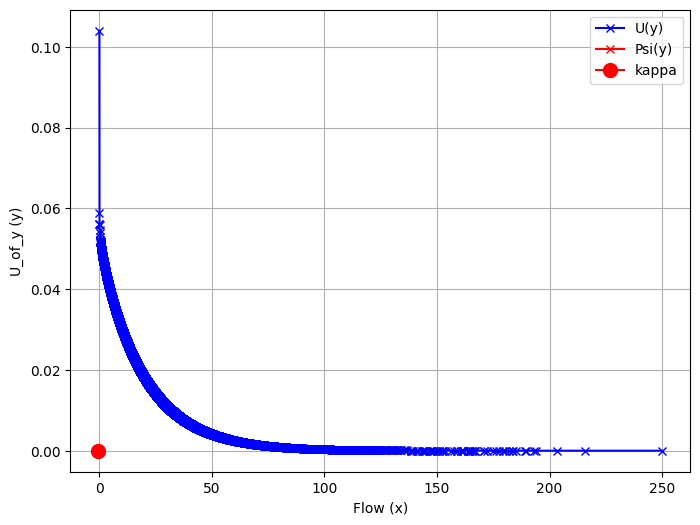

In [342]:
# Check ALIGNMENT
combined_matrix = np.column_stack((y_train.squeeze(), u_of_y.squeeze(), psi.squeeze()))
data = combined_matrix[np.argsort(combined_matrix[:, 0])]
print(data.shape)

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(data[:, 0], data[:, 1], marker='x', linestyle='-', color='b', label='U(y)')
plt.plot(data[:, 0], data[:, 2], marker='x', linestyle='-', color='r', label='Psi(y)')
#plt.hist(data[:, 0], bins=50, color='blue', alpha=0.7)
plt.plot(kappa_max_x, kappa_max_y, marker='o', markersize=10, color='r', label='kappa') 
plt.xlabel('Flow (x)')
plt.ylabel('U_of_y (y)')
#plt.xlim(0,10)
plt.grid(True)
plt.legend()
plt.show()